### Week 10: Logistic regression

By Charlie Eaton

1. Reactions to "The Social Circuitry of High Finance"
2. Probabilities and odds ratios
3. The Maximum Likelihood Estimation (MLE) intuition of logistic regression
4. The magic of logs revisited: Log Likelihoods
5. The MLE logistic equation to maxamize log likelihoods
6. Implementing & Interpreting MLE logistic regression in Stata
7. Postestimation and robustness

### 1. "The Social Circuitry of High Finance"

In [1]:
set more off
log using w10lesson_MLE_logistic20200401.log
use socialcircuitrybillionaires, clear
describe



--------------------------------------------------------------------------------
      name:  <unnamed>
       log:  /Users/Charlie/gradstats2/week10/w10lesson_MLE_logistic20200401.log
  log type:  text
 opened on:   1 Apr 2020, 01:20:50



Contains data from socialcircuitrybillionaires.dta
  obs:         1,200                          
 vars:             6                          1 Apr 2020 01:18
 size:        28,800                          
--------------------------------------------------------------------------------
              storage   display    value
variable name   type    format     label      variable label
--------------------------------------------------------------------------------
year            float   %10.0g                year of observation
boardtop30pri~e float   %9.0g                 held seat on top 30 private
                                                university board
inherited       float   %9.0g                 in Forbes inherited wealth
       

In [2]:
%head if _n<7

,year,boardtop30private,inherited,collegeschooltype,id,pehedge
1,1989,0,0,0,865,0
2,1989,0,0,2,767,0
3,1989,0,1,0,662,0
4,1989,0,0,1,298,0
5,1989,0,0,1,446,0
6,1989,1,0,3,505,1


### 2. Probabilities and odds ratios

* A. With a dichotomous (binary) dependent variable Y, we cannot assume that regression residuals (errors of prediction) are normally distributed as OLS requires. And OLS will predict non-sensical values for Y (outside of the range of 0 to 1)

* B. Instead, logistic regression predicts the logit of dependent variable Y (aka the log of the odds ratio for Y=1) for each observation based on independent variables: $ X_1 ... X_k $

* C. Odds ratios are an expression of the probability that Y=1 is true.

An example from "Social Circuitry":

* Y is a dichotomous/binary dependent variable

* Y = 1 if the Forbes 400 billionaire serves on the board of a top 30 private university that year, and is otherwise 0

* The unconditioned probability that Y=1 is estimated as follows:

### $ p=P(Y=1) = {f_{Y=1} \over N} $

We can estimate probability with a frequency table:

In [20]:
tab boardtop30private


  held seat |
  on top 30 |
    private |
 university |
      board |      Freq.     Percent        Cum.
------------+-----------------------------------
          0 |      1,046       87.17       87.17
          1 |        154       12.83      100.00
------------+-----------------------------------
      Total |      1,200      100.00


### From probability to an odds ratio:

* An odds ratio is the probability of something being true divided by the probability that it is not true.

* The formula for an odds ratio is:

### $ OR = {p \over (1-p)} $

We can write this in Stata:

In [4]:
display "OR = p / (1-p) = " .1283 / (1-.1283)
display "OR = (fy=1 / fy=0) = " 154 / 1046


OR = p / (1-p) = .14718366

OR = (fy=1 / fy=0) = .14722753


### 3. The Maximum Likelihood Estimation (MLE) intuition of logistic regression

* The principle "is to find the value of the "coefficient" that maximizes the likelihood of observing all of the sample data." (Treiman pg. 302)

* This means our model and coefficients predict the **"likelihood"** of Y=1 or Y=0 rather than the value of Y for each observation.

* Think of every observation of Y -- whether they are on a top university board -- for every billionaire in our dataset as involving a flip of a coin resulting in Heads, Y=yes, or Tails, Y=No.

* But the coin toss is never really fair because the coin is weighted.

* We estimate coefficients for our independent variables in logistic regression to predict how much weight towards yes or no (i.e. probability of yes or no) for each billionaire would give us the **Maximum Likelihood** of observing all of our exact data.

* As shown above, just being a billionaire gives someone a .128 chance of being on a top university board. Suppose we think that being a billionaire **private equity or hedge fund manager** gives someone a .25 chance. Here is how it would look in Stata if did 100 flips of a coin that was weighted according to these probabilities:

In [6]:
%set graph_format svg

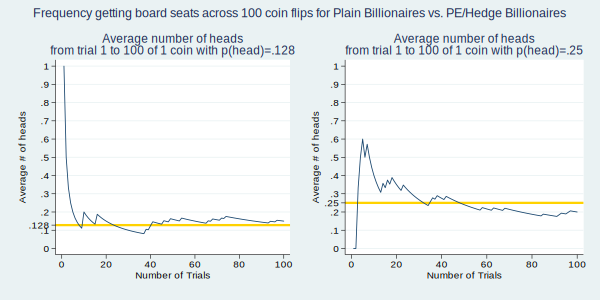

In [13]:
quietly net install heads, from(https://stats.idre.ucla.edu/stat/stata/ado/teach)
quietly heads, flips(100) prob(.128)
quietly graph save plainbillionaires, replace
quietly heads, flips(100) prob(.25)
quietly graph save pehedgebillionaires, replace
graph combine plainbillionaires.gph pehedgebillionaires.gph, ysize(6) xsize(12) iscale(.95) ///
title("Frequency getting board seats across 100 coin flips for Plain Billionaires vs. PE/Hedge Billionaires", size(medlarge))

### 4. The magic of logs revisited: Log Likelihoods

* Maximum Likelihood Estimation (MLE) typically uses log likelihoods in part because logs make calculations easier for humans and computers, especially when it comes to very small probabilities.

* To see this, **try using the calculator on your computer to multiply .01^25 * .01^25.** This is equivalent to multiplying .01 by itself 50 times.

* Logs also have handy properties such as the log of a product, i.e. log(X * Y) being equal to the sum of the logs, i.e. log(X) + log(Y). For example:

In [8]:
display "log(10 * 10) = " log(100)
display "log(10) + log(10) = " log(10) + log(10)


log(10 * 10) = 4.6051702

log(10) + log(10) = 4.6051702


### 5. The MLE logistic equation to maxamize log likelihoods

* What follows is the painful algebraic explanation of the MLE logit model. It should make more sense in a moment when I will illustrate it in an interactive Excel worksheet.

* The MLE logit model equation predicts a logit (aka log odds) for each observation as the log of the odds ratio for the probability that Y=1 ($ p = p_{Y=1} $):

### logit (aka log odds) = $ \log_e(OR) = \log_e(\frac{p}{1-p}) = \alpha + \beta_1 x_1 + ... \beta_2 x_K $

* Maximum Likeihood Estimation then estimates which coefficients maximize "log likelihoods" by predicting logits that express probabilities for Y=1 which are closest to the cumulative probability that Y=1 for each

* The procedures for estimating the logit can be derived from the logit formula as follows:

### $ \frac{p}{1-p} = e^{\alpha + \beta_1 x_1 + ... \beta_2 x_K} $

* further therefore:

### $ {p} = e^{\alpha...} - p \cdot e^{\alpha...}  $
### $ {p} + p \cdot e^{\alpha...} = e^{\alpha...} $
### $ {p} \cdot (1 + e^{\alpha...}) = e^{\alpha...} $
### $ {p} = \frac{e^{\alpha...}}{1 + e^{\alpha...}} $

* The log likelihood for Y=1 | Y=0 based on the logit for **each observation** is then:

### $ {Y} \cdot \ln{\frac{e^{\alpha...}}{1 + e^{\alpha...}}} + (1-Y) \cdot \ln{(1 - \frac{e^{\alpha...}}{1 + e^{\alpha...}})}   $

* So that if Y=1, the higher the logit the higher the log likelihood, but if Y=0, the higher the logit the lower the log likelihood.

* The logistic MLE estimation then iteratively adjusts each regression coefficient upwards and downwards until converging on a coefficient that maximizes the sum of log likelihoods for all observations:

### $  \sum_{i=1}^N {Y_i} \cdot \ln{\frac{e^{\alpha...}}{1 + e^{\alpha...}}} + (1-Y_i) \cdot \ln{(1 - \frac{e^{\alpha...}}{1 + e^{\alpha...}})} $

* Now let's check this out in an interactive spreadsheet. Your task in the spreadsheet is adjust each regression coefficient by hand to maximize the sum of log likelihooks. The worksheet is here: https://github.com/charlieeatonphd/gradstats2/blob/master/week10/socialcircuitry.xlsx

### 6. Implementing & Interpreting MLE logistic regression in Stata

* Lets see how the coefficients estimated by Stata compare to what we estimated by hand:

In [ ]:
logit boardtop30private pehedge inherited collegeschooltype

### But what do these coefficients mean?

* The coefficients are the amount of change expected in the log of the odd ratio for Y=1 for every 1 unit change in X.

* Thinking about the meaning of the coefficents makes my head hurt. So I like to convert them to **odds ratios.**

* To convert the coefficient to an odds ratio we just exponentiate the coefficient (aka take the antilog) as follows:

###  $ \log_e(OR) = \log_e(\frac{p}{1-p}) = \alpha + \beta_1 x_1 + ... \beta_2 x_K $

therefore:

### $ \log_e(OR_\beta{x_1}) = \beta{x_1} $

further therefore:

### $ OR_\beta{x_1} = e^{\beta{x_1}} $

* Or in Stata:

In [9]:
display "OR for beta(pe_hedge) = e^.762881 = " exp(.762881)

OR for beta(pe_hedge) = e^.762881 = 2.1444455


* Or we can get **Odds Ratios** directly from the logistic regression command the **"or"** specification:

In [ ]:
logit boardtop30private pehedge inherited collegeschooltype

### 7. Postestimation and robustness

* Postestimation and robustness precautions are similar to those that apply for OLS regression

* Standard error estimates are evaluated with a Z test rather than a t-test for which P-values have equivalent meanings to their counterparts in OLS.

* You similarly should specify robust or cluster robust standard errors.

* You can also report stored estimates in tables equivalently using esttab. In doing so, for example, we can compare how OLS and MLE yield quite different estimates for university board membership by billionaires:

In [10]:
est clear

quietly eststo: regress boardtop30private pehedge inherited collegeschooltype i.year, cluster(id) ro
quietly eststo: logit boardtop30private pehedge inherited collegeschooltype i.year, cluster(id) ro

In [11]:
%html

esttab ///
, cells(b(star fmt(2)) se(fmt(2) par)) stardetach  ///
	legend starlevels(^ .1 * .05 ** .01 *** .001) html ///
mlabels("OLS" "MLE / logistic") title("unexpontiated coefficients") ///
collabels(none) keep(pehedge inherited collegeschooltype)

This front-end or document format cannot display HTML

* adding **"eform"** to esttab specifies that you want to output odds ratios: 

In [12]:
%html

esttab ///
, cells(b(star fmt(2)) se(fmt(2) par)) stardetach  ///
	legend starlevels(^ .1 * .05 ** .01 *** .001) html ///
mlabels("OLS" "MLE / logistic") title("Odds Ratios") ///
collabels(none) keep(pehedge inherited collegeschooltype) eform

This front-end or document format cannot display HTML